## Walmart weekly sales

Importing libraries & data

In [204]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import seaborn as sns

In [205]:
df = pd.read_csv('data/Walmart_Store_sales.csv')

### EDA

In [206]:
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,6.0,18-02-2011,1572117.54,NaN,59.61,3.045,214.777523,6.858
1,13.0,25-03-2011,1807545.43,0.0,42.38,3.435,128.616064,7.470
2,17.0,27-07-2012,NaN,0.0,NaN,NaN,130.719581,5.936
3,11.0,NaN,1244390.03,0.0,84.57,NaN,214.556497,7.346
4,6.0,28-05-2010,1644470.66,0.0,78.89,2.759,212.412888,7.092


In [207]:
df = df.dropna(subset=['Weekly_Sales'])
# dropping rows with missing values in target

df["Date"]=pd.to_datetime(df["Date"],infer_datetime_format=True)
df = df.sort_values(by ='Date').reset_index(drop=True)
df['Temperature'] = round((df['Temperature'] -32)*5/9,2)
# Processing date as proper datetime format and converting temperature from fahrenheit to celsius

df.describe(include='all',datetime_is_numeric=True)

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,136.000000,118,1.360000e+02,125.000000,121.000000,124.000000,125.000000,122.000000
mean,10.014706,2011-04-23 04:28:28.474576384,1.249536e+06,0.072000,16.030083,3.316992,178.091144,7.665582
min,1.000000,2010-02-05 00:00:00,2.689290e+05,0.000000,-7.340000,2.514000,126.111903,5.143000
25%,4.000000,2010-07-30 00:00:00,6.050757e+05,0.000000,7.340000,2.838500,131.637000,6.690000
50%,10.000000,2011-04-29 00:00:00,1.261424e+06,0.000000,16.810000,3.451000,196.919506,7.477000
75%,15.250000,2011-12-31 18:00:00,1.806386e+06,0.000000,24.420000,3.724000,214.878556,8.150000
max,20.000000,2012-10-19 00:00:00,2.771397e+06,1.000000,33.140000,4.193000,226.968844,14.313000
std,6.124614,NaN,6.474630e+05,0.259528,10.285921,0.479540,40.243105,1.619428


In [208]:
# Dropping outliers : defined as 3 times above or below standard deviation in this project, for the following columns.
df['Temperature']=df['Temperature'].apply(lambda x: np.nan if (np.abs(x - df['Temperature'].mean()) / df['Temperature'].std() > 3) else x)
df['Fuel_Price']=df['Fuel_Price'].apply(lambda x: np.nan if (np.abs(x - df['Fuel_Price'].mean()) / df['Fuel_Price'].std() > 3) else x)
df['CPI']=df['CPI'].apply(lambda x: np.nan if (np.abs(x - df['CPI'].mean()) / df['CPI'].std() > 3) else x)
df['Unemployment']=df['Unemployment'].apply(lambda x: np.nan if (np.abs(x - df['Unemployment'].mean()) / df['Unemployment'].std() > 3) else x)

In [211]:
df = df.dropna(thresh=6)
# dropping row if more than 2 features are missing in the same row

In [212]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 134 entries, 0 to 134
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         134 non-null    float64       
 1   Date          118 non-null    datetime64[ns]
 2   Weekly_Sales  134 non-null    float64       
 3   Holiday_Flag  124 non-null    float64       
 4   Temperature   120 non-null    float64       
 5   Fuel_Price    122 non-null    float64       
 6   CPI           124 non-null    float64       
 7   Unemployment  117 non-null    float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 9.4 KB


In [213]:
print("Missing data in %")
print(df.isna().sum()/len(df)*100)

Missing data in %
Store            0.000000
Date            11.940299
Weekly_Sales     0.000000
Holiday_Flag     7.462687
Temperature     10.447761
Fuel_Price       8.955224
CPI              7.462687
Unemployment    12.686567
dtype: float64


A signicant portion of data is missing, even after we dropped rows where there was no data for the target.

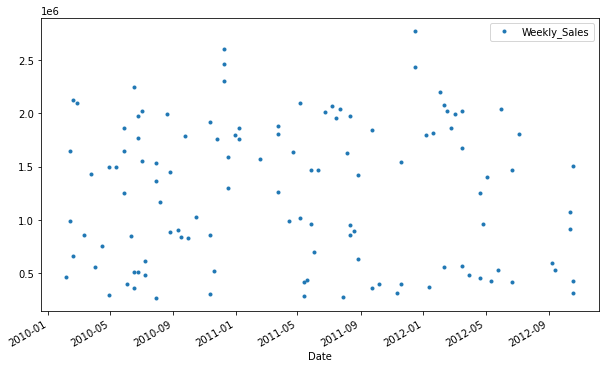

In [214]:
df.plot(x='Date',y='Weekly_Sales',style='.',figsize=(10,6))
plt.show()

Not much of a pattern between dates and weekly sales at first glance !

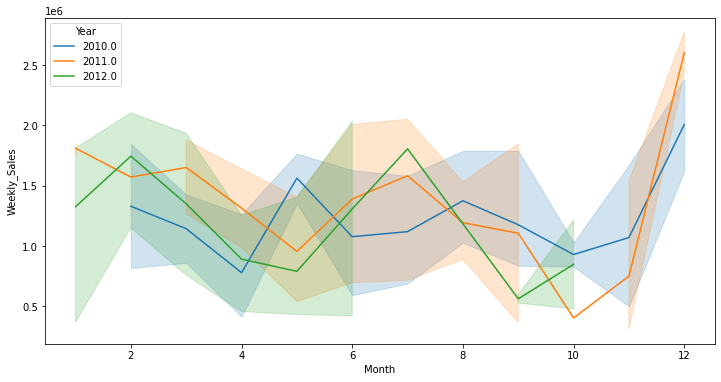

In [215]:
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Day_of_Week'] = df['Date'].dt.day_of_week

plt.figure(figsize=(12,6))
sns.lineplot(data=df,x='Month',y='Weekly_Sales',hue='Year',palette='tab10')
plt.show()

Sales follow the same trends over the years, similar highs and lows though with some offset for 2010.

In [216]:
sales_by_store =df.groupby("Store")["Weekly_Sales"].sum().reset_index(name="Total_Sales").sort_values(by="Total_Sales",ascending=False)

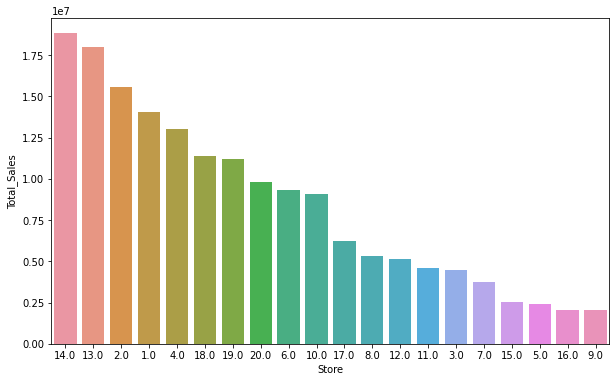

In [217]:
plt.figure(figsize=(10,6))
sns.barplot(x=sales_by_store['Store'],y=sales_by_store['Total_Sales'],order=sales_by_store['Store'])
plt.show()

In [218]:
print(f"Average total sales for one store is $ {round(sales_by_store['Total_Sales'].mean(),2)} out of {len(sales_by_store)} stores.")
print(f"Just one half of the stores make {round(sales_by_store.Total_Sales[:10].sum()/sales_by_store.Total_Sales.sum()*100,2)} % of all sales.")

Average total sales for one store is $ 8441814.15 out of 20 stores.
Just one half of the stores make 77.17 % of all sales.


There is a clear difference in sales between stores. This will likely be useful in our model.

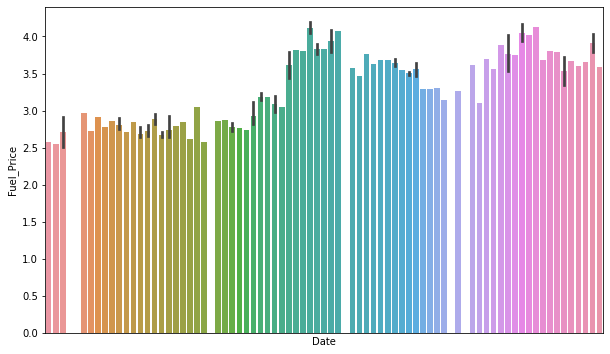

In [219]:
plt.figure(figsize=(10,6))
sns.barplot(y=df['Fuel_Price'],x=df['Date'])
plt.xticks([])
plt.show()

In [220]:
print(f"The price for the gallon of gas went from $ {round(df['Fuel_Price'].min(),2)} to $ {round(df['Fuel_Price'].max(),2)}, between {int(df['Year'].min())} and {int(df['Year'].max())}.")
print(f"The price of gas peaked {df[df['Fuel_Price']== df['Fuel_Price'].max()].values[0,1]}")

The price for the gallon of gas went from $ 2.51 to $ 4.19, between 2010 and 2012.
The price of gas peaked 2011-05-06 00:00:00


In [221]:
df['Holiday_Flag'] = df['Holiday_Flag'].map({1:'Yes',0:'No'})
print(f"Weekly sales around holidays are $ {round(df[df['Holiday_Flag'] == 'Yes']['Weekly_Sales'].mean(),2)}, which is above the average of \
$ {round(df['Weekly_Sales'].mean(),2)}, though the difference is well below standard deviation of $ {round(df['Weekly_Sales'].std(),2)}.")

Weekly sales around holidays are $ 1333024.34, which is above the average of $ 1259972.26, though the difference is well below standard deviation of $ 646247.04.


Spikes in sales are not centered around specific holidays : there may be other parameters or customers start buying well before or after the actual date.

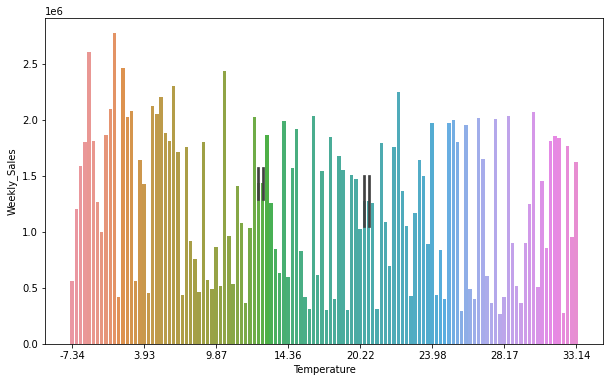

In [222]:
plt.figure(figsize=(10,6))
sns.barplot(y=df['Weekly_Sales'],x=df['Temperature'],order=df['Temperature'].sort_values())
plt.locator_params(axis='both', nbins=8)
plt.show()

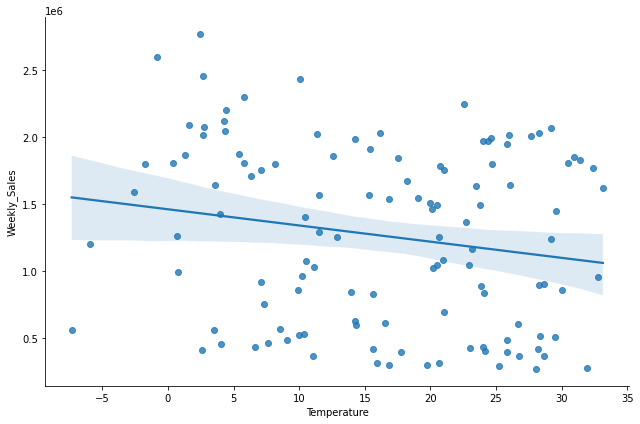

In [223]:
sns.lmplot(data=df,y='Weekly_Sales',x='Temperature',height=6,aspect=1.5)
plt.show()

Temperature is weakly connected with sales, with a bit more at lower temperatures

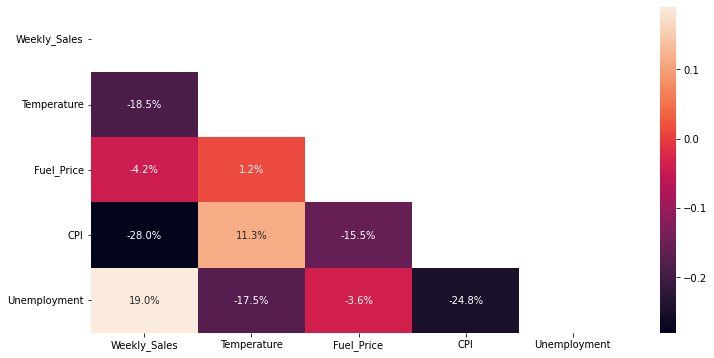

In [226]:
corr = df.iloc[:,2:8].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = 1

plt.figure(figsize=(12,6))
sns.heatmap(corr, annot=True, mask=mask, fmt = '.1%')
plt.show()

Consumer price index may be the best lead we have in numerical features, but will probably be much less significant than stores.

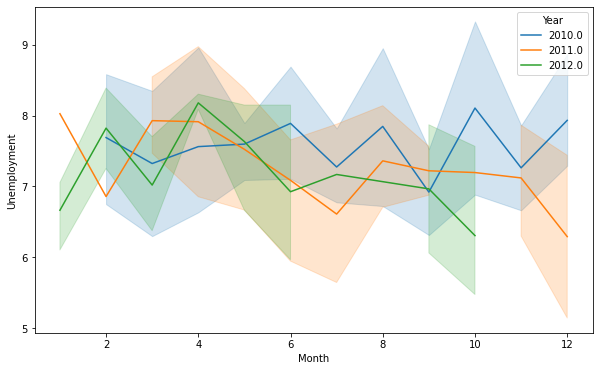

In [227]:
plt.figure(figsize=(10,6))
sns.lineplot(data=df,x='Month',y='Unemployment',hue='Year',palette='tab10')
plt.show()

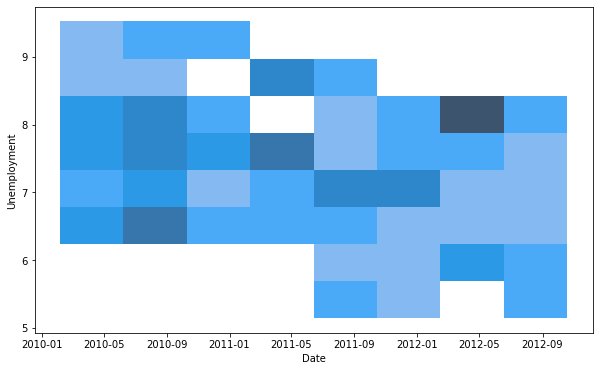

In [228]:
plt.figure(figsize=(10,6))
sns.histplot(data=df,x='Date',y='Unemployment')
plt.show()

Unemployment surged in end of 2010 and first half of 2011/2012 but has gone down since and the trend is still downward.

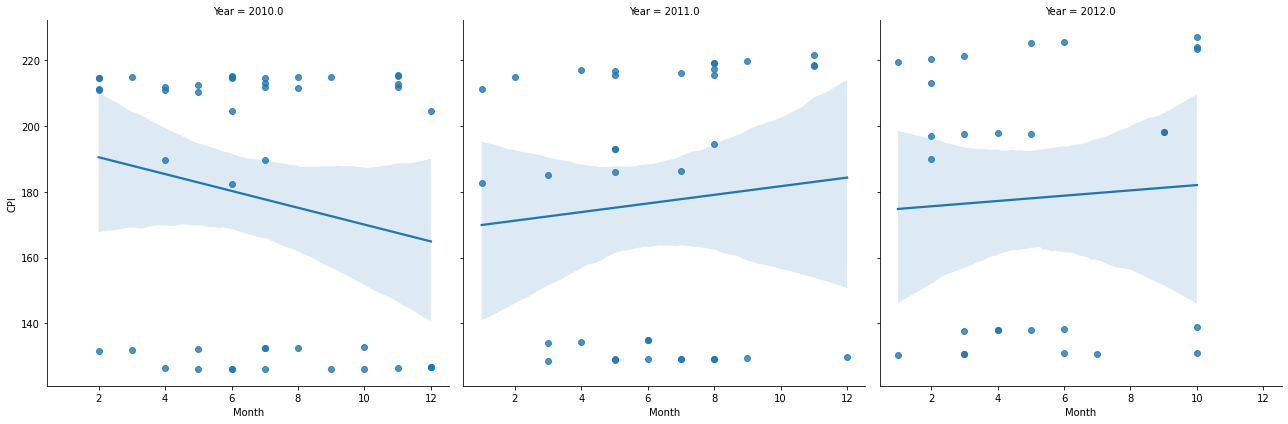

In [229]:
sns.lmplot(data=df, x="Month", y="CPI",col='Year',height=6)
plt.show()

CPI tanked somewhat in 2010 but is globally increasing in 2011 and 2012, despite frequent ups and downs.

### Modeling
With linear regression

In [230]:
X = df.drop(['Date','Weekly_Sales'],axis=1)
y = df['Weekly_Sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [231]:
numeric_features = ['Temperature', 'Fuel_Price','CPI', 'Unemployment'] 
numeric_transformer = Pipeline(steps=[
    ('imputer', KNNImputer()), 
    ('scaler', StandardScaler())
])

# Stores are numbers but nominal data, it is not a ranking
categorical_features = ['Store','Holiday_Flag','Year','Month','Day','Day_of_Week'] 
categorical_transformer = Pipeline(
    steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first',handle_unknown='ignore')) 
    ])

preprocessor = ColumnTransformer(
transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
    ])

In [232]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

Nothing special about encoding numerical & categorical features, but some imputing was necessary to deal with missing values.<br>
Time to implement our baseline model.

In [241]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

y_train_pred = lin_reg.predict(X_train)
Y_test_pred = lin_reg.predict(X_test)

print("r2-score on train set : ", r2_score(y_train, y_train_pred))
print("Standard deviation on train set :", cross_val_score(lin_reg, X_train, y_train, cv=10, scoring='r2').std())
print("r2-score on test set : ", r2_score(y_test, Y_test_pred))

r2-score on train set :  0.9934071098105594
Standard deviation on train set : 0.05459952217340773
r2-score on test set :  0.7655273204056737


Our model gives decent results but is massively overfitting !

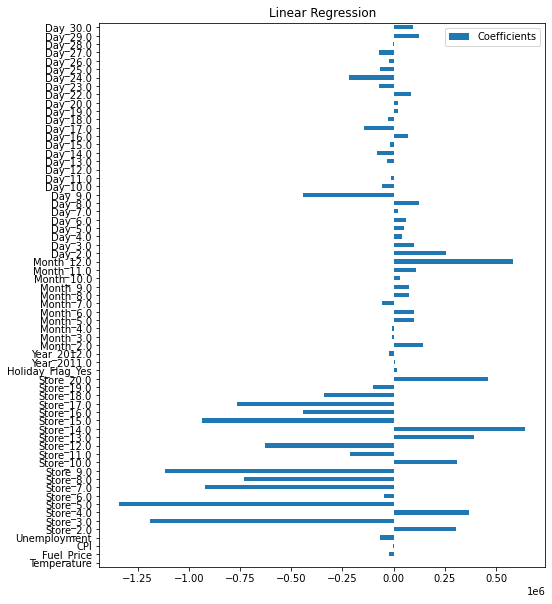

In [242]:
col_names = list(preprocessor.transformers_[0][1].get_feature_names_out()) + list(preprocessor.transformers_[1][1].get_feature_names_out())

coefs = pd.DataFrame(
   lin_reg.coef_,
   columns=['Coefficients'], index=col_names
)

coefs.plot(kind='barh', figsize=(8, 10))
plt.title('Linear Regression')
plt.show()

As expected, stores are the most important features for the model.

In [243]:
model = Ridge()
params = {'alpha':[0.01, 0.02, 0.05, 0.1, 0.5, 1, 10]}

gridsearch = GridSearchCV(model, param_grid = params, cv = 10,scoring='r2') 
gridsearch.fit(X_train, y_train)
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best validation accuracy : ", gridsearch.best_score_)

Best hyperparameters :  {'alpha': 0.02}
Best validation accuracy :  0.936330244196213


In [244]:
model = Lasso(max_iter=2000)
params = {'alpha':[0.1, 1, 10,100,500,1000]}

gridsearch = GridSearchCV(model, param_grid = params, cv = 10,scoring='r2') 
gridsearch.fit(X_train, y_train)
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best validation accuracy : ", gridsearch.best_score_)

Best hyperparameters :  {'alpha': 500}
Best validation accuracy :  0.9467398477628578


In [246]:
lasso = Lasso(alpha=500)
lasso.fit(X_train, y_train)

y_train_pred = lasso.predict(X_train)
Y_test_pred = lasso.predict(X_test)

print("r2-score on train set : ", r2_score(y_train, y_train_pred))
print("Standard deviation on train set :", cross_val_score(lasso, X_train, y_train, cv=10, scoring='r2').std())
print("r2-score on test set : ", r2_score(y_test, Y_test_pred))

r2-score on train set :  0.9914274129033896
Standard deviation on train set : 0.050490857292630704
r2-score on test set :  0.9182272102590894


After trying out the best parameters for Lasso and Ridge, Lasso provided much better r2 score for the test set with less overfitting, compared to the first attempt at linear regression.<br>
To improve further, we could try out other models... And ideally feed more data.